In [1]:
import pandas as pd
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from math import ceil
from datetime import timedelta
from datetime import datetime
import os
from pyomo.core import *
from pyomo.pysp.annotations import StochasticConstraintBoundsAnnotation
from pyomo.environ import RangeSet
from pyomo.opt import SolverFactory

## Prepare dataset

In [2]:
path = 'project 4 dataset/prediction'
folders = os.listdir(path)
folders.sort()
datasets = []

for folder in folders[1:11]:      # ignor .DS_Store file
    list_ = os.listdir(path + '/'+ folder)
    list_.sort()
    print(folder)
    for file in list_:
        print(file)
        if file == '.DS_Store':
            continue
        else:
            df = pd.read_csv(path + '/' + folder + '/' + file)
            df = df.iloc[:7,:]
            df['state'] = str(file)[:-4]
            datasets.append(df)

In [5]:
demands = pd.concat(datasets)

In [8]:
demands = demands.reset_index()

In [10]:
for i in range(raw.shape[0]):
    for j in range(demands.shape[0]):
        if demands.iloc[j]['state'] == raw.iloc[i]['State']:
            demands.loc[demands.index==j, 'StateCode'] = raw.iloc[i]['StateCode']

In [14]:
demands.date = pd.to_datetime(demands.date).dt.strftime('%m/%d/%Y')

In [15]:
demands = demands.sort_values(by = ['StateCode','date'])

In [16]:
# move DC to the end
DC = demands[demands['StateCode'] == 'DC']
demands = pd.concat([demands,DC],ignore_index=True)
demands = demands.drop([i for i in range(490,560)])

In [17]:
demands = demands.reset_index()

In [18]:
#demands.to_csv('predict demand.csv')

In [20]:
demands = demands.iloc[:,3:]

In [129]:
demands

,date,InvVen_upper,InvVen_mean,InvVen_lower,state,StateCode
0,03/25/2020,2.451250,0.233400,0.00000,Alaska,AK
1,03/26/2020,3.700000,0.464050,0.00000,Alaska,AK
2,03/27/2020,5.050000,0.794950,0.00000,Alaska,AK
3,03/28/2020,6.400000,1.244350,0.00000,Alaska,AK
4,03/29/2020,8.103750,1.836650,0.00000,Alaska,AK
...,...,...,...,...,...,...
3565,05/29/2020,76.055263,50.404995,35.79500,District of Columbia,DC
3566,05/30/2020,73.268421,48.422750,33.64875,District of Columbia,DC
3567,05/31/2020,71.638158,46.402608,31.19625,District of Columbia,DC
3568,06/01/2020,69.165789,44.266487,29.24375,District of Columbia,DC


## Set parameters

In [21]:
# Cerdit to Jiajun's Github (structure and logic) https://github.com/jjxu217/COVID-code/tree/main/SR
first_date = '2020/03/25'
t = 7
S = 51
lbd = 0.5
init_ratio = 0.6
flow_bound_ratio = 0.2
stock_bound_ratio = 0.6
prev_date = pd.to_datetime(first_date) - timedelta(t)
raw = pd.read_csv('project 4 dataset/init_data.csv', header=0, index_col=0)
data = raw.rename(columns={'Available capacity': "stock_self"})
data['stock_self'] = round(init_ratio * data['stock_self'])
data['stock_nb'] = None
for i in range(S):
    data.loc[i, 'stock_nb'] = str([0 for _ in eval(data.loc[i, 'nb'])])
data['stock_sns'] = [0 for _ in range(S+1)]
#data.to_csv('firstweek.csv')

In [22]:
# # Cerdit to Jiajun's Github (structure and logic) https://github.com/jjxu217/COVID-code/tree/main/SR
# # read data
t = 7
date = pd.to_datetime(first_date)
prev_date = date - timedelta(t)
#data = pd.read_csv('firstweek.csv',header=0, index_col=0)

idx = 0
flow_mapping = {}
flow_mapping_rev = {}
out_flow = defaultdict(list)
in_flow = defaultdict(list)

for i in range(51):
    nbs = eval(data.iloc[i, 3])
    out_flow[i] = nbs
    for n in nbs:
        flow_mapping[(i, n)] = idx
        flow_mapping_rev[idx] = (i, n)
        in_flow[n].append(i)
        idx += 1

in_flow[51] = []
out_flow[51] = list(range(51))
for n in range(51):
    flow_mapping[(51, n)] = idx
    flow_mapping_rev[idx] = (51, n)
    idx += 1

In [25]:
# Cerdit to Jiajun's Github (structure and logic) https://github.com/jjxu217/COVID-code/tree/main/SR
def covid19(ini_self, ini_nb, week):
    #
    # Model
    #
    model = ConcreteModel()
    #
    # Sets
    #
    t = 7
    S = 51
    F = idx
    model.path = ['InvVen_upper','InvVen_mean','InvVen_lower']
    model.time_set = list(range(1, t + 1))
    model.state_set = list(range(S))
    model.state_p_set = list(range(S + 1))
    model.flow_set = list(range(F))
    model.flow_no_sns_set = list(range(F - S))

    model.U = [round(flow_bound_ratio * ini_self[flow_mapping_rev[j][0]]) for j in model.flow_set] 
    model.G = [round(stock_bound_ratio * i) for i in ini_self]

    # first-stage variables
    model.s0 = Var(model.state_p_set, within=NonNegativeReals)
    model.s0_nb = Var(model.flow_set, within=NonNegativeReals)
    model.x = Var(model.flow_set, within=Reals)

    # second-stage variables
    model.delta1 = Var(model.state_set, model.time_set, within=NonNegativeReals)
    model.delta2 = Var(model.state_set, model.time_set, within=NonNegativeReals)
    model.delta3 = Var(model.state_set, model.time_set, within=NonNegativeReals)

    # always define the objective as the sum of the stage costs
    model.FirstStageCost = Expression(initialize=(lbd*sum(model.s0_nb[i] for i in model.flow_set)))
    model.SecondStageCost1 = Expression(initialize=(sum(model.delta1[s, t] for s in model.state_set for t in model.time_set)))
    model.SecondStageCost2 = Expression(initialize=(sum(model.delta2[s, t] for s in model.state_set for t in model.time_set))) 
    model.SecondStageCost3 = Expression(initialize=(sum(model.delta3[s, t] for s in model.state_set for t in model.time_set)))

    # always define the objective as the sum of the stage costs
    model.obj = Objective(
        expr=model.FirstStageCost + (1/3)*(model.SecondStageCost1+model.SecondStageCost2+model.SecondStageCost3), 
        sense = minimize)



    # first-stage constraints
    model.stock_self = Constraint(model.state_set, rule=lambda model, j: model.s0[j] + \
                              sum(model.x[i] for i in out_flow[j]) -\
                              model.x[flow_mapping[(51, j)]]  == ini_self[j])

    
    model.stock_SNS_self = Constraint(rule=lambda model: model.s0[51] + \
                                      sum(model.x[flow_mapping[(51, i)]] for i in out_flow[51]) == ini_self[51])

    model.stock_nb = Constraint(model.flow_set, rule=lambda model, j: model.s0_nb[j] - \
                                sum(model.x[i] for i in in_flow[j]) == ini_nb[j])
                                   
            

    model.s0_bound = Constraint(model.state_p_set, \
                                    rule=lambda model, j: model.s0[j] >= model.G[j])
    model.x_bound = Constraint(model.flow_set, \
                                    rule=lambda model, j: model.x[j] <= model.U[j])  
    # no ship back to sns
    model.x_sns_bound = Constraint(list(range(F - S, F)), \
                                    rule=lambda model, j: model.x[j] >= 0) 
#     model.ini_nb_bound = Constraint(model.flow_set, \
#                                     rule=lambda model, j: -ini_nb[j] <= model.x[j])
#     model.s0_nb_bound = Constraint(list(range(F - S, F)), \
#                                    rule=lambda model, j: model.s0_nb[j] <= model.U[j])



    length = 70
    model.demand_table = defaultdict(list)
    for j in model.state_set:
        for t in model.time_set:
            for path in model.path:
                model.demand_table[j, t].append([demands.loc[
                    (demands['state'] == demands['state'].iloc[j*length]) &
                    (demands['date'] == demands['date'].iloc[t-1+week])][path][j*length+t-1+week]])

    model.delta1_bound = ConstraintList()
    model.delta2_bound = ConstraintList()
    model.delta3_bound = ConstraintList()

    for j in model.state_set:
        for tt in model.time_set:
            total_stock = model.s0[j] + sum(model.s0_nb[flow_mapping[(i, j)]] for i in out_flow[j])
            model.delta1_bound.add(model.delta1[j, tt] + total_stock - model.demand_table[j, tt][0][0] >= 0)

    for j in model.state_set:
        for tt in model.time_set:
            total_stock = model.s0[j] + sum(model.s0_nb[flow_mapping[(i, j)]] for i in out_flow[j])
            model.delta2_bound.add(model.delta2[j, tt] + total_stock - model.demand_table[j, tt][1][0] >= 0)

    for j in model.state_set:
        for tt in model.time_set:
            total_stock = model.s0[j] + sum(model.s0_nb[flow_mapping[(i, j)]] for i in out_flow[j])
            model.delta3_bound.add(model.delta3[j, tt] + total_stock - model.demand_table[j, tt][2][0] >= 0)

    SolverFactory('glpk').solve(model)
    
    return model

In [26]:
ini_self = [round(i) for i in data['stock_self']]


#read ini_nb by stock_nb data with flow_set
ini_nb = []
for i in range(S):
    for l in range(len(eval(data['stock_nb'][i]))):
        ini_nb.append(eval(data['stock_nb'][i])[l])
for i in data['stock_sns'][:-1]:
    ini_nb.append(i)

In [27]:
np.sum(ini_self)

49772

## Evaluation Data

In [28]:
# read eval dataset
path = 'project 4 dataset/eval'
folders = os.listdir(path)
folders.sort()
datasets_val = {}

for folder in folders[1:]:      # ignor .DS_Store file
    df = pd.read_csv(path + '/' + folder, header = None)
    df.columns = ['date','real demand']
    datasets_val[str(folder)[:-4]] = df
    
validation = pd.concat(datasets_val)

## Calculate unmet Demand

In [123]:
def unmet_demand(week,day1,day2):
    # load the stock_nb in state order
    global nb_list
    nb_list=[]
    for j in range(51):
        sum_nb=0
        for i in in_flow[j]:
            sum_nb=sum_nb+week.s0_nb.extract_values()[flow_mapping[i,j]]

        nb_list.append(sum_nb)
    
    #load the sns in state order
    sns_list=[]
    for i in out_flow[51]:
        sum_sns=0
        sum_sns=sum_sns+week.x.extract_values()[flow_mapping[51,i]]

        sns_list.append(sum_sns)
    
    # calculate the week unmet
    global df_week
    df_week = pd.DataFrame()

    for c,i,j,k,s in zip(list(demands.StateCode.unique()), list(demands.state.unique()),
                         list(week.s0.extract_values().values()),nb_list,sns_list):
        temp = validation.loc[i][day1:day2]
        temp['StateCode'] = c
        temp['state'] = i
        temp['Stock'] = j
        temp['Stock_nb'] = k
        temp['SNS'] = s

        df_week = pd.concat([df_week,temp])
        
    df_week['unmet'] = df_week['Stock']+df_week['Stock_nb']-df_week['real demand']
#     print(df_week)
    unmet = []
    for i in df_week['unmet']:
        if i<0:
            unmet.append(i)

    total_unmet = -np.sum(unmet)
    
    return total_unmet

## Results

In [121]:
week0 = covid19(ini_self,ini_nb, 0)

In [127]:
week0.s0.extract_values()

{0: 120.0,
 1: 806.0,
 2: 300.0,
 3: 900.0,
 4: 6622.0,
 5: 216.0,
 6: 600.0,
 7: 240.0,
 8: 2400.0,
 9: 604.000000000001,
 10: 320.0,
 11: 168.000000000001,
 12: 242.0,
 13: 957.000000000002,
 14: 1156.0,
 15: 101.0,
 16: 780.000000000001,
 17: 653.98985918826,
 18: 840.0,
 19: 577.239436619721,
 20: 149.0,
 21: 1707.9875,
 22: 830.000000000001,
 23: 970.461658841944,
 24: 239.999999999999,
 25: 196.0,
 26: 1276.0,
 27: 245.0,
 28: 216.0,
 29: 600.0,
 30: 988.810035211268,
 31: 332.422535211269,
 32: 435.134585289512,
 33: 2760.0,
 34: 1637.0,
 35: 432.507042253519,
 36: 480.0,
 37: 1200.0,
 38: 213.106416275427,
 39: 686.023474178399,
 40: 315.0,
 41: 569.999999999998,
 42: 5245.0,
 43: 384.320813771515,
 44: 1520.0,
 45: 233.2783333,
 46: 720.0,
 47: 223.0,
 48: 344.128325508607,
 49: 108.0,
 50: 264.0,
 51: 4320.0}

In [124]:
unmet_demand(week0,0,7)

878.131455399056

In [125]:
#df_week.to_csv('week1.csv')

In [78]:
np.sum(list(week0.s0.extract_values().values())) + np.sum(list(week0.s0_nb.extract_values().values())[:222])

49772.00000000001

In [79]:
week1 = covid19(list(week0.s0.extract_values().values()),list(week0.s0_nb.extract_values().values()),7)

In [128]:
week1.s0.extract_values()

{0: 120.0,
 1: 806.0,
 2: 180.0,
 3: 900.0,
 4: 6358.57064001317,
 5: 468.217747398061,
 6: 599.999999999998,
 7: 164.689706111718,
 8: 2367.65406401557,
 9: 604.000000000001,
 10: 319.046747972675,
 11: 168.000000000001,
 12: 145.000000000001,
 13: 957.000000000003,
 14: 1156.0,
 15: 101.0,
 16: 780.000000000001,
 17: 653.98985918826,
 18: 840.0,
 19: 603.191036841703,
 20: 149.0,
 21: 1779.967028,
 22: 830.000000000001,
 23: 1004.4261847823,
 24: 211.399507384423,
 25: 195.999999999999,
 26: 1276.0,
 27: 147.0,
 28: 130.000000000001,
 29: 600.0,
 30: 1009.516393,
 31: 198.999999999998,
 32: 335.743242455931,
 33: 3624.0,
 34: 1553.35441466853,
 35: 260.0,
 36: 480.0,
 37: 1200.0,
 38: 233.0,
 39: 583.023474178399,
 40: 315.000000000002,
 41: 527.8500912,
 42: 5245.0,
 43: 279.428811833855,
 44: 1520.0,
 45: 233.2783333,
 46: 688.284380879563,
 47: 183.951688579563,
 48: 206.0,
 49: 108.0,
 50: 264.0,
 51: 2592.0}

In [80]:
unmet_demand(week1,7,14)

4535.187529800011

In [81]:
#df_week.to_csv('week2.csv')

In [82]:
np.sum(list(week1.s0.extract_values().values())) + np.sum(list(week1.s0_nb.extract_values().values())[:222])

49771.99999999999

In [117]:
week2 = covid19(list(week1.s0.extract_values().values()),list(week1.s0_nb.extract_values().values()),14)

In [118]:
unmet_demand(week2,14,21)

4785.829922999941

In [119]:
#df_week.to_csv('week3.csv')

In [86]:
np.sum(list(week2.s0.extract_values().values())) + np.sum(list(week2.s0_nb.extract_values().values())[:222])

49772.00000000006

In [87]:
week3 = covid19(list(week2.s0.extract_values().values()),list(week2.s0_nb.extract_values().values()),21)

In [88]:
unmet_demand(week3,21,28)

3456.4414934999504

In [89]:
#df_week.to_csv('week4.csv')

In [90]:
np.sum(list(week3.s0.extract_values().values())) + np.sum(list(week3.s0_nb.extract_values().values())[:222])

49772.000000000044

In [91]:
week4 = covid19(list(week3.s0.extract_values().values()),list(week3.s0_nb.extract_values().values()),28)

In [92]:
unmet_demand(week4,28,35)

1505.4414934998886

In [93]:
#df_week.to_csv('week5.csv')

In [94]:
np.sum(list(week4.s0.extract_values().values())) + np.sum(list(week4.s0_nb.extract_values().values())[:222])

49772.00000000003

In [95]:
week5 = covid19(list(week4.s0.extract_values().values()),list(week4.s0_nb.extract_values().values()),35)

In [96]:
unmet_demand(week5,35,42)

713.9984537265066

In [97]:
#df_week.to_csv('week6.csv')

In [98]:
week6 = covid19(list(week5.s0.extract_values().values()),list(week5.s0_nb.extract_values().values()),42)

In [99]:
unmet_demand(week6,42,49)

-0.0

In [100]:
#df_week.to_csv('week7.csv')

In [101]:
week7 = covid19(list(week6.s0.extract_values().values()),list(week6.s0_nb.extract_values().values()),49)

In [102]:
unmet_demand(week7,49,56)

-0.0

In [103]:
#df_week.to_csv('week8.csv')

In [104]:
week8 = covid19(list(week7.s0.extract_values().values()),list(week7.s0_nb.extract_values().values()),56)

In [105]:
unmet_demand(week8,56,63)

-0.0

In [106]:
#df_week.to_csv('week9.csv')

In [107]:
week9 = covid19(list(week8.s0.extract_values().values()),list(week8.s0_nb.extract_values().values()),63)

In [108]:
unmet_demand(week9,63,70)

-0.0

In [109]:
#df_week.to_csv('week10.csv')

In [110]:
unmet_lst = []
list_of_datasets = [ week0, week1, week2, week3, week4, week5, week6, week7, week8, week9]

for index, dataset in enumerate(list_of_datasets):
    unmet_lst.append(unmet_demand(dataset,index*7,(index+1)*7))

### Compare with other situation

In [111]:
real_d = pd.read_csv('eval_v2.csv')

In [112]:
def unmet(weeknum):
    real_d0=real_d.loc[real_d['Week']==weeknum]


    for i in range(51):
        real_d0[str(i)]=real_d0[str(i)]-ini_self[i]
        real_d0[str(i)]=real_d0[str(i)].apply(lambda x: max(0,x))
    return(real_d0.iloc[:,2:].sum(axis=1).sum(axis = 0))

In [113]:
no_coor = []
for i in range (10):
    no_coor.append(unmet(i))

<ipython-input-112-b3b46662e351>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_d0[str(i)]=real_d0[str(i)]-ini_self[i]
<ipython-input-112-b3b46662e351>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_d0[str(i)]=real_d0[str(i)].apply(lambda x: max(0,x))
<ipython-input-112-b3b46662e351>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [114]:
deter = pd.read_csv('determ.csv')
df_result = pd.DataFrame()
df_result['unmet_no_coor'] = no_coor
df_result['unmet_determ'] = deter['0']
df_result['unmet_SR'] = unmet_lst

In [115]:
df_result.index = ['03/25-03/31','04/01-04/07','04/08-04/14','04/15-04/22','04/23-04/29',
                  '04/30-05/05','05/06-05/12','05/13-05/19','05/20-05/26','05/27-06/02']

Text(0, 0.5, 'Unmet demand')

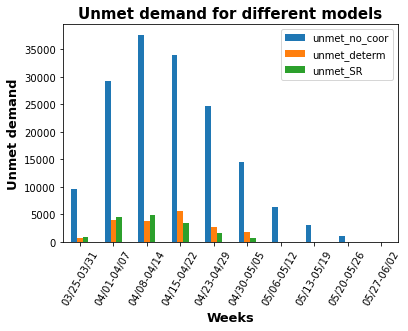

In [116]:
df_result.plot(kind = 'bar')
plt.xticks(rotation=60)
plt.title('Unmet demand for different models', fontweight = 'bold', fontsize = 15)
plt.xlabel('Weeks',fontweight = 'bold',fontsize = 13)
plt.ylabel('Unmet demand',fontweight = 'bold',fontsize = 13)

In [132]:
df_result

,unmet_no_coor,unmet_determ,unmet_SR
03/25-03/31,9501,632.000000,878.131455
04/01-04/07,29295,3978.490215,4535.187530
04/08-04/14,37710,3847.690524,4785.829923
04/15-04/22,34076,5496.961083,3456.441493
04/23-04/29,24742,2708.216000,1505.441493
04/30-05/05,14458,1690.554174,713.998454
05/06-05/12,6320,-0.000000,-0.000000
05/13-05/19,3048,-0.000000,-0.000000
05/20-05/26,958,-0.000000,-0.000000
05/27-06/02,19,-0.000000,-0.000000


In [134]:
total_demand = [38785,80673,107638,114260,108890,98215,86284,74418,63132,53096]

In [135]:
df_result['Total demand'] = total_demand

Text(0, 0.5, 'Total demand')

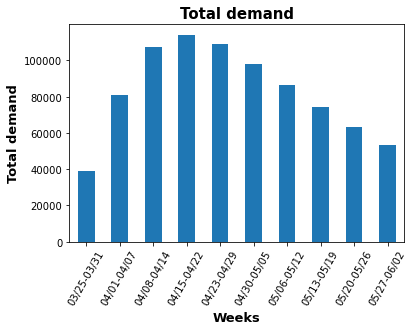

In [140]:
df_result['Total demand'].plot(kind = 'bar')
plt.xticks(rotation=60)
plt.title('Total demand', fontweight = 'bold', fontsize = 15)
plt.xlabel('Weeks',fontweight = 'bold',fontsize = 13)
plt.ylabel('Total demand',fontweight = 'bold',fontsize = 13)

In [143]:
df_result

,unmet_no_coor,unmet_determ,unmet_SR,Total demand
03/25-03/31,9501,632.000000,878.131455,38785
04/01-04/07,29295,3978.490215,4535.187530,80673
04/08-04/14,37710,3847.690524,4785.829923,107638
04/15-04/22,34076,5496.961083,3456.441493,114260
04/23-04/29,24742,2708.216000,1505.441493,108890
04/30-05/05,14458,1690.554174,713.998454,98215
05/06-05/12,6320,-0.000000,-0.000000,86284
05/13-05/19,3048,-0.000000,-0.000000,74418
05/20-05/26,958,-0.000000,-0.000000,63132
05/27-06/02,19,-0.000000,-0.000000,53096
